<a href="https://colab.research.google.com/github/vivekbiragoni/Reinforcement_learning/blob/main/Sarsa_Q_learning_Q_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Relevent link to check up](https://github.com/KhashayarRahimi/ChessRL-Reinforcement-Learning-on-Chess/blob/main/Q-Learning.ipynb)

In [ ]:
!apt-get install stockfish
!cp /usr/games/stockfish /content/sample_data/

!pip install python-chess stockfish tqdm

import chess
import chess.engine
import numpy as np
import random
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 1s (21.1 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00


100%|██████████| 10000/10000 [1:04:40<00:00,  2.58it/s]


AgentWin: 0
StockfishWin: 10000
Draw: 0
Average Reward: -0.0003
Average Reward on Episodes: -0.9754


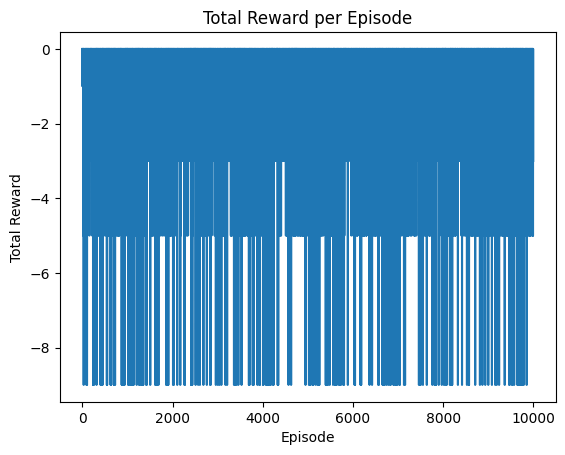

In [ ]:

# Define the RL agent class
class RLAgent:
    def __init__(self, alpha=0.7, gamma=0.9, epsilon=0.5, max_q_values=100):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_q_values = max_q_values
        self.q_values = deque(maxlen=max_q_values)
        self.total_reward = 0
        self.num_games = 0
        self.episode_rewards = []

        # Piece importance values
        self.piece_values = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9
        }

    def get_q_value(self, state, action):
        for q_state, q_action, q_value in self.q_values:
            if q_state == state and q_action == action:
                return q_value
        return 0.0

    # def update_q_value(self, state, action, next_state, reward):
    #     current_q = self.get_q_value(state, action)
    #     next_board = chess.Board(next_state)
    #     legal_actions = self.get_legal_actions(next_board)
    #     if legal_actions:
    #         max_q = max(self.get_q_value(next_state, a) for a in legal_actions)
    #     else:
    #         max_q = 0.0
    #     new_q = current_q + self.alpha * (reward + self.gamma * max_q - current_q)
    #     self.q_values.append((state, action, new_q))


    # SARSA
    def update_q_value(self, state, action, next_state, next_action, reward):
        current_q = self.get_q_value(state, action)
        next_q = self.get_q_value(next_state, next_action)
        new_q = current_q + self.alpha * (reward + self.gamma * next_q - current_q)
        self.q_values.append((state, action, new_q))


    def get_legal_actions(self, board):
        return list(board.legal_moves)

    def choose_action(self, state):
        board = chess.Board(state)
        if random.random() < self.epsilon:
            return random.choice(self.get_legal_actions(board))
        else:
            return self.get_best_action(board)

    def get_best_action(self, board):
        legal_actions = self.get_legal_actions(board)
        best_action = legal_actions[0]
        max_q = self.get_q_value(board.fen(), best_action)
        for action in legal_actions:
            q_value = self.get_q_value(board.fen(), action)
            if q_value > max_q:
                best_action = action
                max_q = q_value
        return best_action

    def get_reward(self, captured_piece):
        if captured_piece.piece_type == chess.KING:
            return 100
        elif captured_piece.piece_type in self.piece_values:
            return self.piece_values[captured_piece.piece_type]
        else:
            return 0

    def play_game(self):
        board = chess.Board()
        # engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
        engine = chess.engine.SimpleEngine.popen_uci("/content/sample_data/stockfish")


        while not board.is_game_over():
            if board.turn == chess.WHITE:
                state = board.fen()
                action = self.choose_action(state)
                board.push(action)
                reward = 0.0

                captured_piece = board.piece_at(action.to_square)
                if captured_piece is not None:
                    reward = self.get_reward(captured_piece)

                next_state = board.fen()
                # self.update_q_value(state, action, next_state,reward)
                next_action = self.choose_action(next_state)  # Select next action
                self.update_q_value(state, action, next_state, next_action, reward)
            else:
                result = engine.play(board, chess.engine.Limit(time=0.01))
                captured_piece = board.piece_at(result.move.to_square)
                if captured_piece is not None:
                    reward = -self.get_reward(captured_piece)
                else:
                    reward = 0.0
                board.push(result.move)

        engine.quit()

        result = board.result()
        self.num_games += 1
        self.total_reward += reward
        self.episode_rewards.append(self.total_reward)

        return result

    def calculate_average_reward(self):
        if self.num_games > 0:
            return self.total_reward / self.num_games
        else:
            return 0.0


AgentWin, StockfishWin, Draw = 0, 0, 0
# Create and train the RL agent
agent = RLAgent()
episode_rewards = []

for _ in tqdm(range(10000)):
    agent.total_reward = 0

    result = agent.play_game()

    if result == '1-0':
        AgentWin += 1
    elif result == '0-1':
        StockfishWin += 1
    else:
        Draw += 1

    if len(agent.q_values) > agent.max_q_values:
        agent.q_values.popleft()

    episode_rewards.append(agent.total_reward)

print('AgentWin:', AgentWin)
print('StockfishWin:', StockfishWin)
print('Draw:', Draw)

average_reward = agent.calculate_average_reward()
print('Average Reward:', average_reward)

print('Average Reward on Episodes:', np.mean(episode_rewards))

# Plot the episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


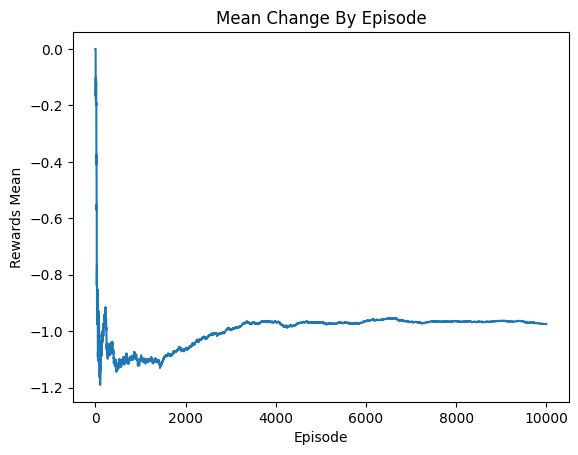

In [ ]:
Stepwise_Mean = []

#EpisodeRewards = E_rewards.tolist()

for i in range(len(episode_rewards)):

    zero_to_step_i = episode_rewards[:i]

    Mean = np.mean(zero_to_step_i)

    Stepwise_Mean.append(Mean)

# Plot the episode rewards
plt.plot(Stepwise_Mean)
plt.xlabel('Episode')
plt.ylabel('Rewards Mean')
plt.title('Mean Change By Episode')
plt.show()


# RLC2 Second part of the notebook: Q-networks
In this notebook We implement an simplified version of chess named capture chess. In this environment the agent (playing white) is rewarded for capturing pieces (not for checkmate).  After running this notebook, you end up with an agent that can capture pieces against a random oponnent as demonstrated in the gif below. The main difference between this notebook and the previous one is that We use Q-networks as an alternative to Q-tables. Q-tables are nice and straightforward, but can only contain a limited amount of action values. Chess has state space complexity of 10<sup>47</sup>. Needless to say, this is too much information to put in a Q-table. This is where supervised learning comes in. A Q-network can represent a generalized mapping from state to action values.

![](https://images.chesscomfiles.com/uploads/game-gifs/90px/green/neo/0/cc/0/0/aXFZUWpyN1Brc1BPbHQwS211WEhudkh6cXohMGFPMExPUTJNUTY4MDY1OTI1NFpSND8yOT85M1Y5MTA3MUxLQ3RDUkpDSjcwTE0wN293V0d6Rzc2cHhWTXJ6NlhzQVg0dUM0WGNNWDU,.gif)

#### Import and Install

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package

  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-jjvnps05
  Running command git clone --filter=blob:none --quiet https://github.com/arjangroen/RLC.git /tmp/pip-req-build-jjvnps05
  Resolved https://github.com/arjangroen/RLC.git to commit e54eb7380875f64fd06106c59aa376b426d9e5ca
  Preparing metadata (setup.py) ... done


In [ ]:
from keras.models import Model, clone_model
from keras.layers import Input, Conv2D, Dense, Reshape, Dot, Activation, Multiply
from keras.optimizers import SGD
import numpy as np
import keras.backend as K


def policy_gradient_loss(Returns):
    def modified_crossentropy(action, action_probs):
        cost = (K.categorical_crossentropy(action, action_probs, from_logits=False, axis=1) * Returns)
        return K.mean(cost)

    return modified_crossentropy


class Agent(object):

    def __init__(self, gamma=0.5, network='linear', lr=0.01, verbose=0):
        """
        Agent that plays the white pieces in capture chess
        Args:
            gamma: float
                Temporal discount factor
            network: str
                'linear' or 'conv'
            lr: float
                Learning rate, ideally around 0.1
        """
        self.gamma = gamma
        self.network = network
        self.lr = lr
        self.verbose = verbose
        self.init_network()
        self.weight_memory = []
        self.long_term_mean = []

    def init_network(self):
        """
        Initialize the network
        Returns:

        """
        if self.network == 'linear':
            self.init_linear_network()
        elif self.network == 'conv':
            self.init_conv_network()
        elif self.network == 'conv_pg':
            self.init_conv_pg()

    def fix_model(self):
        """
        The fixed model is the model used for bootstrapping
        Returns:
        """
        # optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        optimizer = SGD(lr=self.lr, momentum=0.0,  nesterov=False)
        self.fixed_model = clone_model(self.model)
        self.fixed_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        self.fixed_model.set_weights(self.model.get_weights())

    def init_linear_network(self):
        """
        Initialize a linear neural network
        Returns:

        """
        # optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        optimizer = SGD(lr=self.lr, momentum=0.0, nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        reshape_input = Reshape((512,))(input_layer)
        output_layer = Dense(4096)(reshape_input)
        self.model = Model(inputs=[input_layer], outputs=[output_layer])
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def init_conv_network(self):
        """
        Initialize a convolutional neural network
        Returns:

        """
        # optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        optimizer = SGD(lr=self.lr, momentum=0.0,  nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        inter_layer_1 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        inter_layer_2 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        flat_1 = Reshape(target_shape=(1, 64))(inter_layer_1)
        flat_2 = Reshape(target_shape=(1, 64))(inter_layer_2)
        output_dot_layer = Dot(axes=1)([flat_1, flat_2])
        output_layer = Reshape(target_shape=(4096,))(output_dot_layer)
        self.model = Model(inputs=[input_layer], outputs=[output_layer])
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    def init_conv_pg(self):
        """
        Convnet net for policy gradients
        Returns:

        """
        # optimizer = SGD(lr=self.lr, momentum=0.0, decay=0.0, nesterov=False)
        optimizer = SGD(lr=self.lr, momentum=0.0, nesterov=False)
        input_layer = Input(shape=(8, 8, 8), name='board_layer')
        R = Input(shape=(1,), name='Rewards')
        legal_moves = Input(shape=(4096,), name='legal_move_mask')
        inter_layer_1 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        inter_layer_2 = Conv2D(1, (1, 1), data_format="channels_first")(input_layer)  # 1,8,8
        flat_1 = Reshape(target_shape=(1, 64))(inter_layer_1)
        flat_2 = Reshape(target_shape=(1, 64))(inter_layer_2)
        output_dot_layer = Dot(axes=1)([flat_1, flat_2])
        output_layer = Reshape(target_shape=(4096,))(output_dot_layer)
        softmax_layer = Activation('softmax')(output_layer)
        legal_softmax_layer = Multiply()([legal_moves, softmax_layer])  # Select legal moves
        self.model = Model(inputs=[input_layer, R, legal_moves], outputs=[legal_softmax_layer])
        self.model.compile(optimizer=optimizer, loss=policy_gradient_loss(R))

    def network_update(self, minibatch):
        """
        Update the Q-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """

        # Prepare separate lists
        states, moves, rewards, new_states = [], [], [], []
        td_errors = []
        episode_ends = []
        for sample in minibatch:
            states.append(sample[0])
            moves.append(sample[1])
            rewards.append(sample[2])
            new_states.append(sample[3])

            # Episode end detection
            if np.array_equal(sample[3], sample[3] * 0):
                episode_ends.append(0)
            else:
                episode_ends.append(1)

        # The Q target
        q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(
            self.fixed_model.predict(np.stack(new_states, axis=0)), axis=1)

        # The Q value for the remaining actions
        q_state = self.model.predict(np.stack(states, axis=0))  # batch x 64 x 64

        # Combine the Q target with the other Q values.
        q_state = np.reshape(q_state, (len(minibatch), 64, 64))
        for idx, move in enumerate(moves):
            td_errors.append(q_state[idx, move[0], move[1]] - q_target[idx])
            q_state[idx, move[0], move[1]] = q_target[idx]
        q_state = np.reshape(q_state, (len(minibatch), 4096))

        # Perform a step of minibatch Gradient Descent.
        self.model.fit(x=np.stack(states, axis=0), y=q_state, epochs=1, verbose=0)

        return td_errors

    def get_action_values(self, state):
        """
        Get action values of a state
        Args:
            state: np.ndarray with shape (8,8,8)
                layer_board representation

        Returns:
            action values

        """
        return self.fixed_model.predict(state) + np.random.randn() * 1e-9

    def policy_gradient_update(self, states, actions, rewards, action_spaces, actor_critic=False):
        """
        Update parameters with Monte Carlo Policy Gradient algorithm
        Args:
            states: (list of tuples) state sequence in episode
            actions: action sequence in episode
            rewards: rewards sequence in episode

        Returns:

        """
        n_steps = len(states)
        Returns = []
        targets = np.zeros((n_steps, 64, 64))
        for t in range(n_steps):
            action = actions[t]
            targets[t, action[0], action[1]] = 1
            if actor_critic:
                R = rewards[t, action[0] * 64 + action[1]]
            else:
                R = np.sum([r * self.gamma ** i for i, r in enumerate(rewards[t:])])
            Returns.append(R)

        if not actor_critic:
            mean_return = np.mean(Returns)
            self.long_term_mean.append(mean_return)
            train_returns = np.stack(Returns, axis=0) - np.mean(self.long_term_mean)
        else:
            train_returns = np.stack(Returns, axis=0)
        # print(train_returns.shape)
        targets = targets.reshape((n_steps, 4096))
        self.weight_memory.append(self.model.get_weights())
        self.model.fit(x=[np.stack(states, axis=0),
                          train_returns,
                          np.concatenate(action_spaces, axis=0)
                          ],
                       y=[np.stack(targets, axis=0)],
                       verbose=self.verbose
                       )

In [ ]:
import chess
from chess.pgn import Game
import RLC
from RLC.capture_chess.environment import Board
from RLC.capture_chess.learn import Q_learning
# from RLC.capture_chess.agent import Agent

### The environment: Capture Chess
In this notebook we'll upgrade our environment to one that behaves more like real chess. It is mostly based on the Board object from python-chess.
Some modifications are made to make it easier for the algorithm to converge:
* There is a maximum of 25 moves, after that the environment resets
* Our Agent only plays white
* The Black player is part of the environment and returns random moves
* The reward structure is not based on winning/losing/drawing but on capturing black pieces:
    - pawn capture: +1
    - knight capture: +3
    - bishop capture: +3
    - rook capture: +5
    - queen capture: +9
* Our state is represent by an 8x8x8 array
    - Plane 0 represents pawns
    - Plane 1 represents rooks
    - Plane 2 represents knights
    - Plane 3 represents bishops
    - Plane 4 represents queens
    - Plane 5 represents kings
    - Plane 6 represents 1/fullmove number (needed for markov property)
    - Plane 7 represents can-claim-draw
* White pieces have the value 1, black pieces are minus 1
       


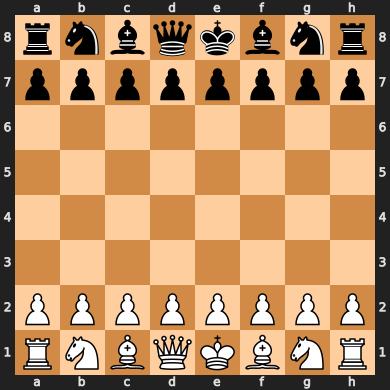

In [ ]:
board = Board()
board.board

#### Numerical representation of the pawns (layer 0)
Change the index of the first dimension to see the other pieces

In [ ]:
board.layer_board[0,::-1,:].astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

### The Agent
* The agent is no longer a single piece, it's a chess player
* Its action space consist of 64x64=4096 actions:
    * There are 8x8 = 64 piece from where a piece can be picked up
    * And another 64 pieces from where a piece can be dropped.
* Of course, only certain actions are legal. Which actions are legal in a certain state is part of the environment (in RL, anything outside the control of the agent is considered part of the environment). We can use the python-chess package to select legal moves. (It seems that AlphaZero uses a similar approach https://ai.stackexchange.com/questions/7979/why-does-the-policy-network-in-alphazero-work)

In [ ]:
import tensorflow as tf

board = Board()
# optimizer = tf.keras.optimizers.Adam(learning_rate=agent.lr)
agent = Agent(network='conv',gamma=0.1,lr=0.07)
R = Q_learning(agent,board)
R.agent.fix_model()
R.agent.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board_layer (InputLayer)    [(None, 8, 8, 8)]            0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 1, 8, 8)              9         ['board_layer[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)           (None, 1, 8, 8)              9         ['board_layer[0][0]']         
                                                                                                  
 reshape_3 (Reshape)         (None, 1, 64)                0         ['conv2d_2[0][0]']            
                                                                                            

In [ ]:
print(inspect.getsource(agent.network_update))

    def network_update(self, minibatch):
        """
        Update the Q-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """

        # Prepare separate lists
        states, moves, rewards, new_states = [], [], [], []
        td_errors = []
        episode_ends = []
        for sample in minibatch:
            states.append(sample[0])
            moves.append(sample[1])
            rewards.append(sample[2])
            new_states.append(sample[3])

            # Episode end detection
            if np.array_equal(sample[3], sample[3] * 0):
                episode_ends.append(0)
            else:
                episode_ends.append(1)

        # The Q target
        q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(
            self.fi

#### Q learning with a Q-network
**Theory**
- The Q-network is usually either a linear regression or a (deep) neural network.
- The input of the network is the state (S) and the output is the predicted action value of each Action (in our case, 4096 values).
- The idea is similar to learning with Q-tables. We update our Q value in the direction of the discounted reward + the max successor state action value
- I used prioritized experience replay to de-correlate the updates. If you want to now more about it, check the link in the references
> - I used fixed-Q targets to stabilize the learning process.

#### Implementation
- I built two networks, A linear one and a convolutional one
- The linear model maps the state (8,8,8) to the actions (64,64), resulting in over 32k trainable weights! This is highly inefficient because there is no parameter sharing, but it will work.
- The convolutional model uses 2 1x1 convulutions and takes the outer product of the resulting arrays. This results in only 18 trainable weights!
    - Advantage: More parameter sharing -> faster convergence
    - Disadvantage: Information gets lost -> lower performance
- For a real chess AI we need bigger neural networks. But now the neural network only has to learn to capture valuable pieces.

In [ ]:
print(inspect.getsource(R.play_game))

    def play_game(self, k, greedy=False, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        # Here we determine the exploration rate. k is divided by 250 to slow down the exploration rate decay.
        eps = max(0.05, 1 / (1 + (k / 250))) if not greedy else 0.

        # Play a game of chess
        while not episode_end:
            state = self.env.layer_board
            explore = np.random.uniform(0, 1) < eps  # determine whether to explore
            if explore:
                move = self.env.get_random_action()
                move_from = move.from_square
                move_to = move.to_square
            else:
                ac

### Demo

iter 0
31/31 [==============================] - 0s 2ms/step


iter 10
31/31 [==============================] - 0s 2ms/step


iter 20
31/31 [==============================] - 0s 2ms/step


iter 30
31/31 [==============================] - 0s 2ms/step


iter 40
31/31 [==============================] - 0s 2ms/step


iter 50
31/31 [==============================] - 0s 2ms/step


iter 60
31/31 [==============================] - 0s 2ms/step


iter 70
31/31 [==============================] - 0s 2ms/step


iter 80
31/31 [==============================] - 0s 2ms/step


iter 90
31/31 [==============================] - 0s 2ms/step


iter 100
31/31 [==============================] - 0s 2ms/step


iter 110
31/31 [==============================] - 0s 2ms/step
iter 120


31/31 [==============================] - 0s 2ms/step


iter 130
31/31 [==============================] - 0s 2ms/step


iter 140
31/31 [==============================] - 0s 2ms/step


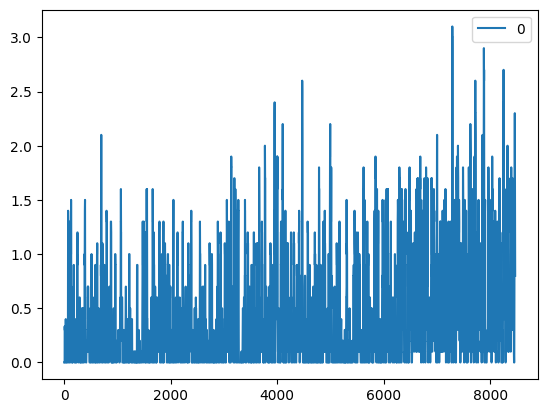

In [ ]:
pgn = R.learn(iters=150)

<Axes: title={'center': 'average performance over the last 125 steps'}>

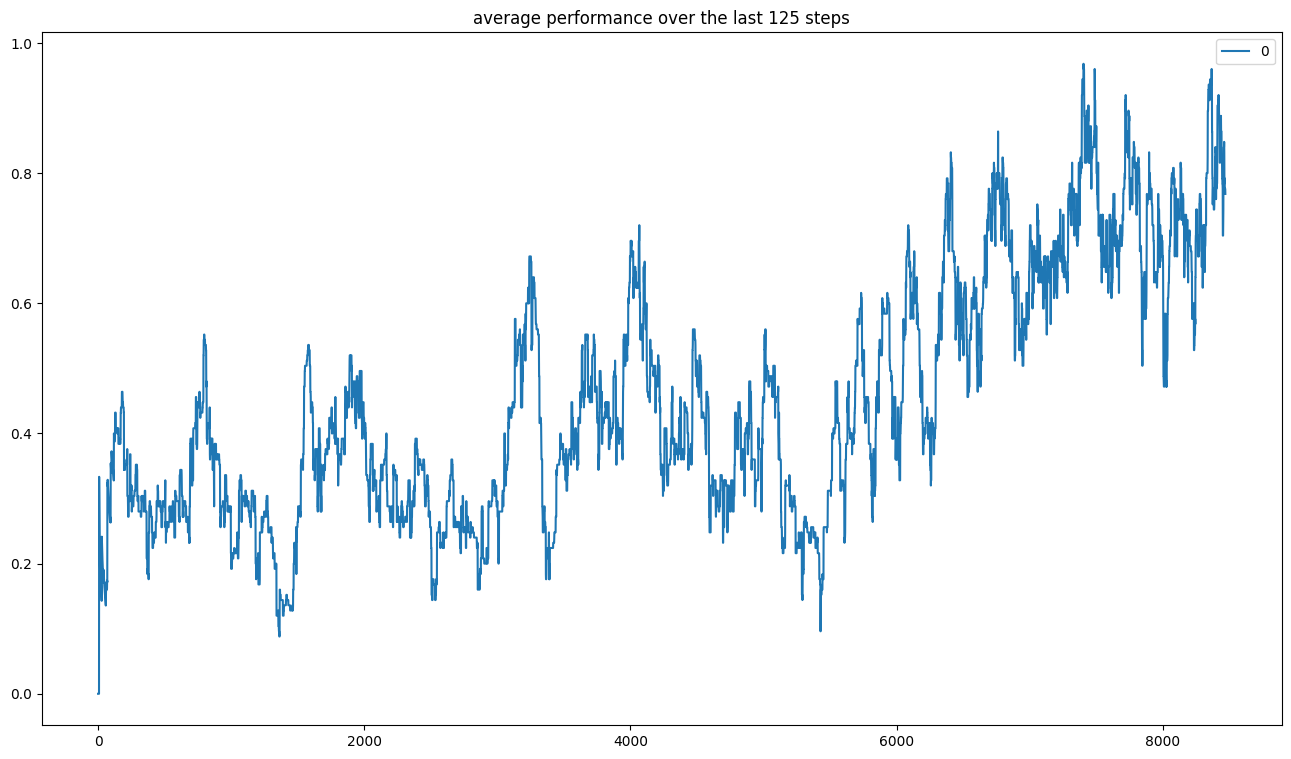

In [ ]:
reward_smooth = pd.DataFrame(R.reward_trace)
reward_smooth.rolling(window=125,min_periods=0).mean().plot(figsize=(16,9),title='average performance over the last 125 steps')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/final_game1.pgn","w") as log:
# with open("final_game.pgn","w") as log:
    log.write(str(pgn))

## Learned action values analysis
So what has the network learned? The code below checks the action values of capturing every black piece for every white piece.
- We expect that the action values for capturing black pieces is similar to the (Reinfeld) rewards we put in our environment.
- Of course the action values also depend on the risk of re-capture by black and the opportunity for consecutive capture.

In [ ]:
board.reset()
bl = board.layer_board
bl[6,:,:] = 1/10  # Assume we are in move 10
av = R.agent.get_action_values(np.expand_dims(bl,axis=0))

av = av.reshape((64,64))

p = board.board.piece_at(20)#.symbol()


white_pieces = ['P','N','B','R','Q','K']
black_piece = ['_','p','n','b','r','q','k']

df = pd.DataFrame(np.zeros((6,7)))

df.index = white_pieces
df.columns = black_piece

for from_square in range(16):
    for to_square in range(30,64):
        from_piece = board.board.piece_at(from_square).symbol()
        to_piece = board.board.piece_at(to_square)
        if to_piece:
            to_piece = to_piece.symbol()
        else:
            to_piece = '_'
        df.loc[from_piece,to_piece] = av[from_square,to_square]

1/1 [==============================] - 0s 23ms/step


In [ ]:
df[['_','p','n','b','r','q']]

,_,p,n,b,r,q
P,1.811074,1.873068,2.706515,3.142313,2.467904,5.020144
N,0.778665,0.805319,1.163657,1.351027,1.061067,2.158395
B,1.308303,1.353087,1.955162,2.269978,1.782792,3.626507
R,1.238096,1.280476,1.850242,2.148164,1.687121,3.431897
Q,1.509422,1.561090,2.255718,2.618929,2.056850,4.183990
K,0.976058,1.009469,1.458647,1.693515,1.330050,2.705552


## References
Reinforcement Learning: An Introduction  
> Richard S. Sutton and Andrew G. Barto  
> 1st Edition  
> MIT Press, march 1998  

RL Course by David Silver: Lecture playlist  
> https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ  

Experience Replay  
> https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits